### Load Library

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

### Load in Test and Validation Data

- y_test and y_val labels have to be converted to integer for roc computation
- x_test and x_val needs to have certain columns dropped

In [6]:
## Load in Test Set
X_test_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/test/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)

y_test_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/test/y_test.parquet"
y_test = pd.read_parquet(y_test_path)
y_test = pd.DataFrame(y_test['label'].astype(int)) ## convert labels to int for roc auc calculation

## Load in Validation Set
X_val_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/validation/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)

y_val_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/validation/y_val.parquet"
y_val = pd.read_parquet(y_val_path)
y_val = pd.DataFrame(y_val['label'].astype(int))

y_train_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/y_train.parquet"
y_train = pd.read_parquet(y_train_path)
y_train = pd.DataFrame(y_train['label'].astype(int))

### Create Functions Needed For :

- Basic Classification
- Hyperparameter tuning using Randomized Search CV
    - The optimal size of the hidden layer is usually between the size of the input and size of the output layers.
        - Input layers is the number of features (we have 37, so round off to 40)
        - Output layer has 2 nodes. 
        - https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
- Feature Selection

link to understand MLP different parameters

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [2]:
## function for basic classification
def mlp(x_train, y_train, x_val, y_val, x_test, y_test, variable,
        max_iter = 200, hidden_layer_sizes = (100, ), activation = "relu",
        solver = "adam", alpha = 0.0001, learning_rate = "constant"):
    ## create classifier
    clf = MLPClassifier(random_state = 1, max_iter = max_iter, hidden_layer_sizes = hidden_layer_sizes,
                        activation = activation, solver = solver, alpha = alpha, learning_rate = learning_rate)

    ## train the model
    clf.fit(x_train, y_train)

    ## get validation and test predicition
    y_val_pred = clf.predict(x_val)
    print('Accuracy of multi-layer perceptron classifier on validation set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_val, y_val_pred)))
   
    y_test_pred = clf.predict(x_test)
    print('Accuracy of multi-layer perceptron classifier on test set using {}: {:.2f}'.format(variable, metrics.accuracy_score(y_test, y_test_pred)))

    ## define metrics for roc
    y_test_pred_proba = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    mlp_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    ## create roc curve   
    plt.figure()
    plt.plot(fpr, tpr, label = 'Mulit-Layer Perceptron Classifier (area = %0.2f)' % mlp_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

    ## define metric for precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
    auc_precision_recall = auc(recall, precision)

    ## create pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'Mulit-Layer Perceptron Classifier (area = %0.2f)' % auc_precision_recall)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

In [3]:
## defining param_grid

# Max number of iterations
max_iter = [int(x) for x in np.linspace(200, 300, num = 11)]

# Number of neurons in the hidden layer
hidden_layer_sizes = [(int(x), ) for x in np.linspace(50, 150, num = 10)]

# Activation function for hidden layer
activation = ['identity', 'logistic', 'tanh', 'relu']

# Solver for weight optimization
solver = ['lbfgs', 'sgd', 'adam']

# Strength of L2 regularisation term
alpha = list(np.arange(0.01, 0.05, 0.005))

# Learning rate schedule for weight updates
learning_rate = ['constant', 'invscaling', 'adaptive']

random_grid = {
    'max_iter': max_iter,
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': activation,
    'solver': solver,
    'alpha': alpha,
    'learning_rate': learning_rate
}

print(random_grid)

{'max_iter': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300], 'hidden_layer_sizes': [(50,), (61,), (72,), (83,), (94,), (105,), (116,), (127,), (138,), (150,)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.01, 0.015, 0.019999999999999997, 0.024999999999999998, 0.03, 0.034999999999999996, 0.039999999999999994, 0.045], 'learning_rate': ['constant', 'invscaling', 'adaptive']}


In [4]:
## function for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

def params_tuning(param_grid, X_train, y_train):
    clf = MLPClassifier(random_state = 1)

    ## random search of parameters using 3 fold cross validation
    clf_random = RandomizedSearchCV(estimator = clf, param_distributions = param_grid, n_iter = 50, cv = 3, random_state = 7, n_jobs = -1)
    clf_random.fit(X_train, y_train)

    return clf_random.best_params_

In [6]:
## function for feature selection
from sklearn.feature_selection import SelectFromModel

def var_selection(X_train, y_train, rf):
    sel = SelectFromModel(rf)
    sel.fit(X_train, y_train)

    return X_train.columns[(sel.get_support())]

# Modelling on 25th Quantile

In [7]:
## define columns to drop
cols_to_drop_25 = ['dwelling_time_-1_50', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'std_-1_50', 'std_-1_75', 'std_-1_mean', 'mean_-1_50', 'mean_-1_75', 'mean_-1_mean',
                'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'std_0_50', 'std_0_75', 'std_0_mean', 'mean_0_50', 'mean_0_75', 'mean_0_mean',
                'dwelling_time_+1_50', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'std_+1_50', 'std_+1_75', 'std_+1_mean', 'mean_+1_50', 'mean_+1_75', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_25 = X_val.drop(columns = cols_to_drop_25, axis = 1)

## dropping columns from X_test set
X_test_25 = X_test.drop(columns = cols_to_drop_25, axis = 1)

## Load X_train_25
X_train_25_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_25.parquet" ## to edit file path
X_train_25 = pd.read_parquet(X_train_25_path)

In [8]:
print(f"Number of Rows for X_train_25 and y_train: {len(X_train_25)}, {len(y_train)}")
print(f"Number of Rows for X_test_25 and y_test: {len(X_test_25)}, {len(y_test)}")
print(f"Number of Rows for X_val_25 and y_val: {len(X_val_25)}, {len(y_val)}")

Number of Rows for X_train_25 and y_train: 30406, 30406
Number of Rows for X_test_25 and y_test: 11825, 11825
Number of Rows for X_val_25 and y_val: 12143, 12143


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of multi-layer perceptron classifier on validation set using 25th quantile: 0.95
Accuracy of multi-layer perceptron classifier on test set using 25th quantile: 0.95


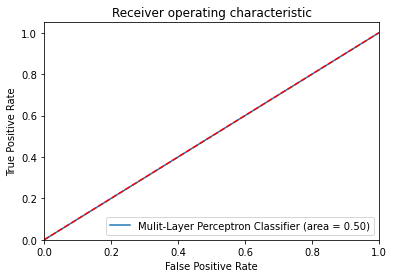

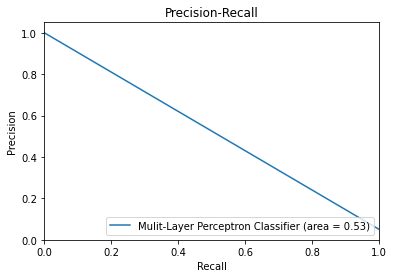

In [9]:
mlp(X_train_25, y_train, X_val_25, y_val, X_test_25, y_test, "25th quantile")

## Feature Selection

In [ ]:
mlp_fs_25 = MLPClassifier(random_state = 1)
mlp_fs_25.fit(X_train_25, y_train)

best_var_25 = var_selection(X_train_25, y_train, mlp_fs_25)
print(best_var_25)

mlp(X_train_25[list(best_var_25)], y_train, X_val_25[list(best_var_25)], y_val, X_test_25[list(best_var_25)], y_test, "25th quantile")

## Hyperparameter Tuning

In [11]:
best_param_25 = params_tuning(random_grid, X_train_25, y_train)
best_param_25

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'solver': 'lbfgs',
 'max_iter': 270,
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (50,),
 'alpha': 0.015,
 'activation': 'logistic'}

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy of multi-layer perceptron classifier on validation set using 25th quantile: 0.95
Accuracy of multi-layer perceptron classifier on test set using 25th quantile: 0.95


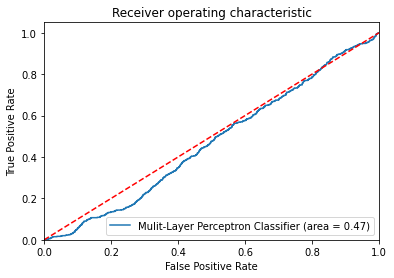

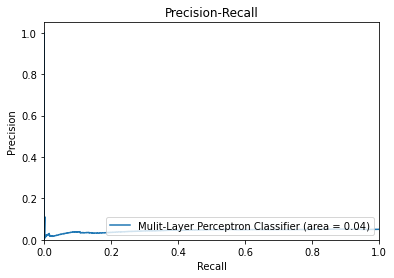

In [12]:
mlp(X_train_25, y_train, X_val_25, y_val, X_test_25, y_test, "25th quantile",
    max_iter = 270, hidden_layer_sizes = (50, ), activation = "logistic", solver = 'lbfgs', alpha = 0.015, learning_rate = "invscaling")

# Modelling on 50th Quantile

In [13]:
## define columns to drop
cols_to_drop_50 = ['dwelling_time_-1_25', 'dwelling_time_-1_75', 'dwelling_time_-1_mean', 'std_-1_25', 'std_-1_75', 'std_-1_mean', 'mean_-1_25', 'mean_-1_75', 'mean_-1_mean',
                'dwelling_time_0_25', 'dwelling_time_0_75', 'dwelling_time_0_mean', 'std_0_25', 'std_0_75', 'std_0_mean', 'mean_0_25', 'mean_0_75', 'mean_0_mean',
                'dwelling_time_+1_25', 'dwelling_time_+1_75', 'dwelling_time_+1_mean', 'std_+1_25', 'std_+1_75', 'std_+1_mean', 'mean_+1_25', 'mean_+1_75', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_50 = X_val.drop(columns = cols_to_drop_50, axis = 1)

## dropping columns from X_test set
X_test_50 = X_test.drop(columns = cols_to_drop_50, axis = 1)

## Load X_train_50
X_train_50_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_50.parquet" ## to edit file path
X_train_50 = pd.read_parquet(X_train_50_path)

In [14]:
## check if training data are the same len
print(f"Number of Rows for X_train_50 and y_train: {len(X_train_50)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_50 and y_val: {len(X_val_50)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_50 and y_test: {len(X_test_50)}, {len(y_test)}")

Number of Rows for X_train_50 and y_train: 30406, 30406
Number of Rows for X_val_50 and y_val: 12143, 12143
Number of Rows for X_test_50 and y_test: 11825, 11825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of multi-layer perceptron classifier on validation set using 50th quantile: 0.95
Accuracy of multi-layer perceptron classifier on test set using 50th quantile: 0.95


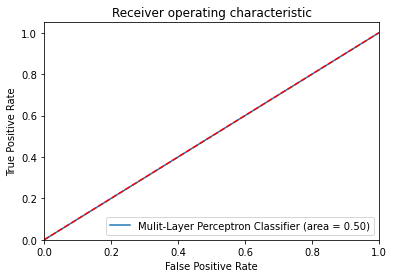

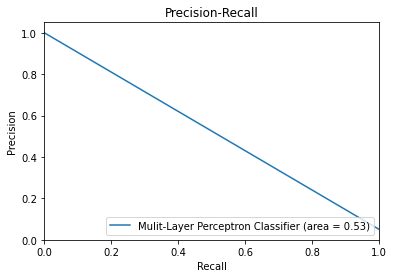

In [15]:
mlp(X_train_50, y_train, X_val_50, y_val, X_test_50, y_test, "50th quantile")

## Hyperparameter Tuning

In [16]:
best_param_50 = params_tuning(random_grid, X_train_50, y_train)
best_param_50

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'solver': 'lbfgs',
 'max_iter': 300,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (150,),
 'alpha': 0.015,
 'activation': 'relu'}

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy of multi-layer perceptron classifier on validation set using 50th quantile: 0.95
Accuracy of multi-layer perceptron classifier on test set using 50th quantile: 0.95


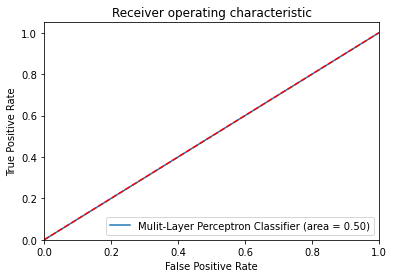

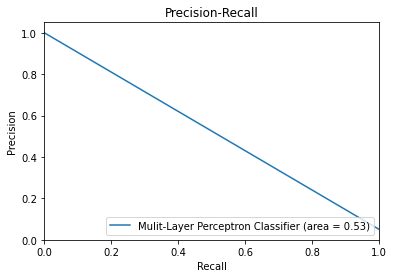

In [17]:
mlp(X_train_50, y_train, X_val_50, y_val, X_test_50, y_test, "50th quantile",
    max_iter = 300, hidden_layer_sizes = (150, ), activation = "relu", solver = 'lbfgs', alpha = 0.015, learning_rate = "adaptive")

# Modelling on 75th Quantile

In [23]:
## define columns to drop
cols_to_drop_75 = ['dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_mean', 'std_-1_25', 'std_-1_50', 'std_-1_mean', 'mean_-1_25', 'mean_-1_50', 'mean_-1_mean',
                    'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_mean', 'std_0_25', 'std_0_50', 'std_0_mean', 'mean_0_25', 'mean_0_50', 'mean_0_mean',
                    'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_mean', 'std_+1_25', 'std_+1_50', 'std_+1_mean', 'mean_+1_25', 'mean_+1_50', 'mean_+1_mean']

## dropping columns from X_validation set
X_val_75 = X_val.drop(columns = cols_to_drop_75, axis = 1)

## dropping columns from X_test set
X_test_75 = X_test.drop(columns = cols_to_drop_75, axis = 1)

## Load X_train_75
X_train_75_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_75.parquet" ## to edit file path
X_train_75 = pd.read_parquet(X_train_75_path)

In [24]:
## check if training data are the same len
print(f"Number of Rows for X_train_75 and y_train: {len(X_train_75)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_75 and y_val: {len(X_val_75)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_75 and y_test: {len(X_test_75)}, {len(y_test)}")

Number of Rows for X_train_75 and y_train: 30406, 30406
Number of Rows for X_val_75 and y_val: 12143, 12143
Number of Rows for X_test_75 and y_test: 11825, 11825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of multi-layer perceptron classifier on validation set using 75th quantile: 0.95
Accuracy of multi-layer perceptron classifier on test set using 75th quantile: 0.95


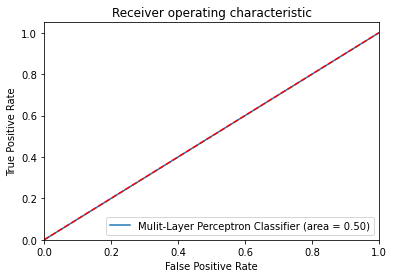

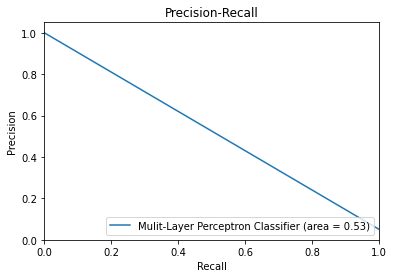

In [25]:
mlp(X_train_75, y_train, X_val_75, y_val, X_test_75, y_test, "75th quantile")

## Hyperparameter Tuning

In [26]:
best_param_75 = params_tuning(random_grid, X_train_75, y_train)
best_param_75

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'solver': 'lbfgs',
 'max_iter': 300,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (116,),
 'alpha': 0.024999999999999998,
 'activation': 'relu'}

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy of multi-layer perceptron classifier on validation set using 75th quantile: 0.95
Accuracy of multi-layer perceptron classifier on test set using 75th quantile: 0.95


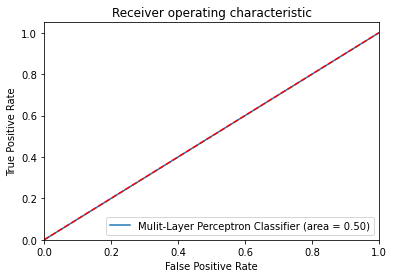

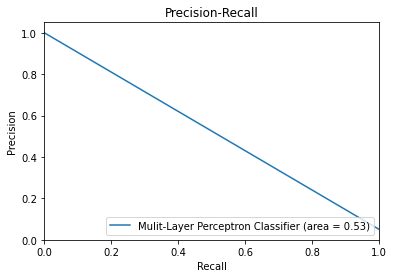

In [27]:
mlp(X_train_75, y_train, X_val_75, y_val, X_test_75, y_test, "75th quantile",
    max_iter = 300, hidden_layer_sizes = (116, ), activation = "relu", solver = 'lbfgs', alpha = 0.024999999999999998, learning_rate = "constant")

# Modelling on Mean

In [18]:
## define columns to drop
cols_to_drop_mean = ['dwelling_time_-1_25', 'dwelling_time_-1_50', 'dwelling_time_-1_75', 'std_-1_25', 'std_-1_50', 'std_-1_75', 'mean_-1_25', 'mean_-1_50', 'mean_-1_75',
                    'dwelling_time_0_25', 'dwelling_time_0_50', 'dwelling_time_0_75', 'std_0_25', 'std_0_50', 'std_0_75', 'mean_0_25', 'mean_0_50', 'mean_0_75',
                    'dwelling_time_+1_25', 'dwelling_time_+1_50', 'dwelling_time_+1_75', 'std_+1_25', 'std_+1_50', 'std_+1_75', 'mean_+1_25', 'mean_+1_50', 'mean_+1_75']

## dropping columns from X_validation set
X_val_mean = X_val.drop(columns = cols_to_drop_mean, axis = 1)

## dropping columns from X_test set
X_test_mean = X_test.drop(columns = cols_to_drop_mean, axis = 1)

## Load X_train_mean
X_train_mean_path = "/Users/claudia/DSA4262-ACMXZ/data/new_preprocessed_data/training/X_train_mean.parquet" ## to edit file path
X_train_mean = pd.read_parquet(X_train_mean_path)

In [19]:
## check if training data are the same len
print(f"Number of Rows for X_train_mean and y_train: {len(X_train_mean)}, {len(y_train)}")

## check if validation data are the same len
print(f"Number of Rows for X_val_mean and y_val: {len(X_val_mean)}, {len(y_val)}")

## check if test data are the same len
print(f"Number of Rows for X_test_mean and y_test: {len(X_test_mean)}, {len(y_test)}")

Number of Rows for X_train_mean and y_train: 30406, 30406
Number of Rows for X_val_mean and y_val: 12143, 12143
Number of Rows for X_test_mean and y_test: 11825, 11825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of multi-layer perceptron classifier on validation set using mean: 0.95
Accuracy of multi-layer perceptron classifier on test set using mean: 0.95


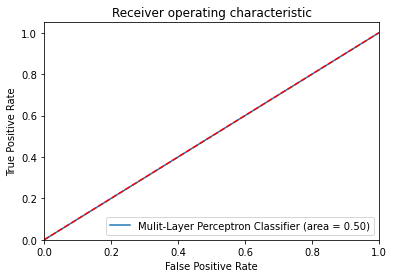

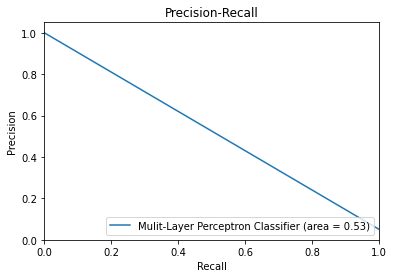

In [20]:
mlp(X_train_mean, y_train, X_val_mean, y_val, X_test_mean, y_test, "mean")

## Hyperparameter Tuning

In [21]:
best_param_mean = params_tuning(random_grid, X_train_mean, y_train)
best_param_mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'solver': 'lbfgs',
 'max_iter': 270,
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (50,),
 'alpha': 0.015,
 'activation': 'logistic'}

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy of multi-layer perceptron classifier on validation set using mean: 0.95
Accuracy of multi-layer perceptron classifier on test set using mean: 0.95


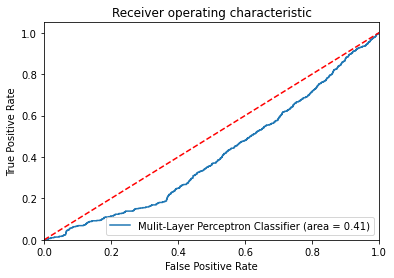

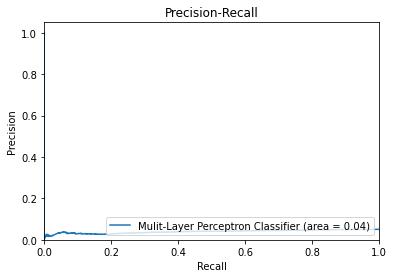

In [22]:
mlp(X_train_mean, y_train, X_val_mean, y_val, X_test_mean, y_test, "mean",
    max_iter = 270, hidden_layer_sizes = (50, ), activation = "logistic", solver = 'lbfgs', alpha = 0.015, learning_rate = "invscaling")